In [1]:
import os
import glob

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2

from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D

Using TensorFlow backend.


In [2]:
%matplotlib inline

alignImages method is used to centralize and align input data images with background we have. This is necessary in order to extract the background using bitwise extraction operation.

In [3]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

def alignImages(im1, im2):

    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    #cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h


extract_background method extracts the background and denoises a bit the outup image

In [4]:
def extract_background(imReg, imBackground):
    # extract the background
    final = cv2.bitwise_not(cv2.bitwise_not(imReg) - cv2.bitwise_not(imBackground))
    # Denoising
    img =  cv2.bitwise_not(final)
    kernel = np.ones((2,2),np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    res_Morph = cv2.bitwise_not(opening)

    return res_Morph

generate_string method is used to generate a string extension for newly generated data images (to extend training data)

In [5]:
def generate_string():
    generated_string = ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for _ in range(8))
    return generated_string

In [6]:
fixed_part =[]
input_part = []
user_part = []

# read background images (table form)
for (root,dirs,files) in os.walk("./images/fixed_part/"):
    for file in files:
        if file.endswith('.jpg'):
            im = cv2.imread(os.path.join(root, file), cv2.IMREAD_COLOR)
            fixed_part.append((file, im))

# read images with fullfiled info (table form with user hand writting)
for (root,dirs,files) in os.walk("./images/input/"):
    for file in files:
        if file.endswith('.jpg'):
            im = cv2.imread(os.path.join(root, file), cv2.IMREAD_COLOR)
            input_part.append((file, im))

# read images with already cleaned data (inly user input)
for (root,dirs,files) in os.walk("./images/user_part/"):
    for file in files:
        if file.endswith('.jpg'):
            im = cv2.imread(os.path.join(root, file), cv2.IMREAD_COLOR)
            user_part.append((file, im))

In [7]:
print(len(input_part))

3


In [9]:
aligned_part = []
subtracted_part = []

print("Aligning images ...")
for fixed_img, input_img in zip(fixed_part, input_part):
    imReg, h = alignImages(input_img[1], fixed_img[1])
    aligned_part.append((input_img[0], imReg))
    cv2.imwrite("./images/aligned/" + input_img[0], imReg)

print("Extract background ...")
for aligned_img, fixed_img in zip(aligned_part, fixed_part):
    res_Morph = extract_background(aligned_img[1], fixed_img[1])
    subtracted_part.append((aligned_img[0], res_Morph))
    cv2.imwrite("./images/subtracted/" + aligned_img[0], res_Morph)


Aligning images ...
Extract background ...


In [10]:
print(len(aligned_part))

3


If you want to enlarge the training dataset run following commented code. At the moment we have only 3 images

In [11]:
# import random, string

# print("Expanding subset of user_part and subtracted images ...")
# added_subtracted = []
# added_user = []
# for subtracted_img, user_img in zip(subtracted_part, user_part):
#     generated_string_horizontal = generate_string()
#     generated_string_vertical = generate_string()
#     horizontal_sub_img = cv2.flip( subtracted_img[1], 0 )
#     vertical_sub_img = cv2.flip( subtracted_img[1], 1 )
#     horizontal_user_img = cv2.flip( user_img[1], 0 )
#     vertical_user_img = cv2.flip( user_img[1], 1 )
#     added_subtracted.append(( "sample( " + generated_string_horizontal + " ).jpg",horizontal_sub_img))
#     added_subtracted.append(( "sample( " + generated_string_vertical + " ).jpg",vertical_sub_img))
#     added_user.append(( "sample( " + generated_string_horizontal + " ).jpg",horizontal_user_img))
#     added_user.append(("sample( " + generated_string_vertical + " ).jpg",vertical_user_img))
#     cv2.imwrite("./images/subtracted/sample( " + generated_string_horizontal + " ).jpg", horizontal_sub_img)
#     cv2.imwrite("./images/subtracted/sample( " + generated_string_vertical + " ).jpg", vertical_sub_img)
#     cv2.imwrite("./images/user_part/sample( " + generated_string_horizontal + " ).jpg", horizontal_user_img)
#     cv2.imwrite("./images/user_part/sample( " + generated_string_vertical + " ).jpg", vertical_user_img)
#     #
# for subtracted_img, user_img in zip(added_subtracted, added_user):
#     subtracted_part.append(subtracted_img)
#     user_part.append(user_img)

# subtracted_shift_part_images = []
# user_shift_part_images = []
#     #
# M_shifts = [np.float32([[1,0,50],[0,1,0]]), np.float32([[1,0,0],[0,1,50]]), np.float32([[1,0,-50],[0,1,0]]), np.float32([[1,0,0],[0,1,-50]]),
#             np.float32([[1,0,25],[0,1,0]]), np.float32([[1,0,0],[0,1,25]]), np.float32([[1,0,-25],[0,1,0]]), np.float32([[1,0,0],[0,1,-25]]),
#             np.float32([[1,0,50],[0,1,50]]), np.float32([[1,0,-50],[0,1,50]]), np.float32([[1,0,-50],[0,1,-50]]), np.float32([[1,0,50],[0,1,-50]]),
#             np.float32([[1,0,25],[0,1,25]]), np.float32([[1,0,-25],[0,1,25]]), np.float32([[1,0,-25],[0,1,-25]]), np.float32([[1,0,25],[0,1,-25]]),
#             np.float32([[1,0,25],[0,1,50]]), np.float32([[1,0,-25],[0,1,50]]), np.float32([[1,0,-25],[0,1,-50]]), np.float32([[1,0,25],[0,1,-50]]),
#             np.float32([[1,0,50],[0,1,25]]), np.float32([[1,0,-50],[0,1,25]]), np.float32([[1,0,-50],[0,1,-25]]), np.float32([[1,0,50],[0,1,-25]])]
# for subtracted_img, user_img in zip(subtracted_part, user_part):
#     rows,cols,_ = subtracted_img[1].shape
#     for M in M_shifts:
#         subtracted_dst = cv2.warpAffine(subtracted_img[1],M,(cols,rows), borderValue=(255,255,255))
#         user_dst = cv2.warpAffine(user_img[1],M,(cols,rows), borderValue=(255,255,255))
#         generated_string_shift = generate_string()
#         subtracted_shift_part_images.append(( "sample( " + generated_string_shift + " ).jpg",subtracted_dst))
#         user_shift_part_images.append(( "sample( " + generated_string_shift + " ).jpg",user_dst))
#         cv2.imwrite("./images/subtracted/sample( " + generated_string_shift + " ).jpg", subtracted_dst)
#         cv2.imwrite("./images/user_part/sample( " + generated_string_shift + " ).jpg", user_dst)
    
# for subtracted_img, user_img in zip(subtracted_shift_part_images, user_shift_part_images):
#     subtracted_part.append(subtracted_img)
#     user_part.append(user_img)


In [12]:
print(len(subtracted_part))
print(len(user_part))

3
3


In oreder to use autoencoders we have to make all images to have the same size. Here we register the sige for each image and after denoise we can cut back the images at their original size.

In [13]:
import csv

x_img = []
y_img = []

with open('img_file.csv', mode='w') as img_file:
    for subtracted_img, user_img in zip(subtracted_part, user_part):
        img_writer = csv.writer(img_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        img_writer.writerow([subtracted_img[0], subtracted_img[1].shape])
        img_writer.writerow([user_img[0], user_img[1].shape])
        x_img.append((subtracted_img[0], subtracted_img[1]))
        y_img.append((user_img[0], user_img[1]))

Currecnt max values are 2540 and 3322. Because 3322 is not divisible by 4 we enlarge max length with 2. In this case we get 2540 and 3324

In [18]:
max_width = 2540
max_length = 3324

# for subtracted_img in x_img:
#     length, width, _ = subtracted_img[1].shape
#     if max_width < width:
#         max_width = width
#     if max_length < length:
#         max_length = length

In [19]:
for subtracted_img, user_img in zip(x_img, y_img):
    length, width, _ = subtracted_img[1].shape
    copy_sub=cv2.copyMakeBorder(subtracted_img[1], top=max_length - length, bottom=0, left=0, right=max_width - width, borderType= cv2.BORDER_CONSTANT, value=[255,255,255] )
    copy_user=cv2.copyMakeBorder(user_img[1], top=max_length - length, bottom=0, left=0, right=max_width - width, borderType= cv2.BORDER_CONSTANT, value=[255,255,255] )
    cv2.imwrite("./images/res_x/" + subtracted_img[0], copy_sub)
    cv2.imwrite("./images/res_y/" + user_img[0], copy_user)
    

In [20]:
TRAIN_IMAGES = glob.glob('./images/res_x/*.jpg')
CLEAN_IMAGES = glob.glob('./images/res_y/*.jpg')
TEST_IMAGES = glob.glob('./images/res_x/sample (2).jpg')

In [21]:
user_img[1].shape

(3322, 2540, 3)

In [22]:
def load_image_form(path):
    image_list = np.zeros((len(path), 3324, 2540, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(3324, 2540))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x     
    
    return image_list

In [23]:
x_train = load_image_form(TRAIN_IMAGES)
y_train = load_image_form(CLEAN_IMAGES)
x_test = load_image_form(TEST_IMAGES)

print(x_train.shape, x_test.shape)

(3, 3324, 2540, 1) (1, 3324, 2540, 1)


In [24]:
def train_val_split(x_train, y_train):
    rnd = np.random.RandomState(seed=42)
    perm = rnd.permutation(len(x_train))
    train_idx = perm[:int(0.8 * len(x_train))]
    val_idx = perm[int(0.8 * len(x_train)):]
    return x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]

x_train, y_train, x_val, y_val = train_val_split(x_train, y_train)
print(x_train.shape, x_val.shape)


(2, 3324, 2540, 1) (1, 3324, 2540, 1)


Autoencoder class using Keras

In [22]:
# class Autoencoder():
#     def __init__(self):
#         self.img_rows = 3324
#         self.img_cols = 2540
#         self.channels = 1
#         self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
#         optimizer = Adam(lr=0.001)
        
#         self.autoencoder_model = self.build_model()
#         self.autoencoder_model.compile(loss='mse', optimizer=optimizer)
#         self.autoencoder_model.summary()
    
#     def build_model(self):
#         input_layer = Input(shape=self.img_shape)
        
#         # encoder
#         h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
#         h = MaxPooling2D((2, 2), padding='same')(h)
#         h = Conv2D(32, (3, 3), activation='relu', padding='same')(h)
#         encoded = MaxPooling2D((2, 2), padding='same')(h)
        
#         # decoder
#         h = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
#         h = UpSampling2D((2, 2))(h)
#         h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
#         h = UpSampling2D((2, 2))(h)
#         output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h) #decoded
        
#         return Model(input_layer, output_layer)
    
#     def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20):
#         early_stopping = EarlyStopping(monitor='val_loss',
#                                        min_delta=0,
#                                        patience=5,
#                                        verbose=1, 
#                                        mode='auto')
#         history = self.autoencoder_model.fit(x_train, y_train,
#                                              batch_size=batch_size,
#                                              epochs=epochs,
#                                              validation_data=(x_val, y_val),
#                                              callbacks=[early_stopping])
#         plt.plot(history.history['loss'])
#         plt.plot(history.history['val_loss'])
#         plt.title('Model loss')
#         plt.ylabel('Loss')
#         plt.xlabel('Epoch')
#         plt.legend(['Train', 'Test'], loc='upper left')
#         plt.show()
    
#     def eval_model(self, x_test):
#         preds = self.autoencoder_model.predict(x_test)
#         return preds

In [ ]:
for simplyfication (to run autoencoder in less time) we will use just a method that returns an autoencoder.

In [25]:
def build_autoenocder():
    input_img = Input(shape=(3324,2540,1), name='image_input')
    
    #enoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
   
    #decoder

    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = UpSampling2D((2,2), name='upsample3')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv3')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='Adagrad', loss='binary_crossentropy')
    return autoencoder

In [26]:
autoencoder = build_autoenocder()
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 3324, 2540, 1)     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 3324, 2540, 32)    320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 1662, 1270, 32)    0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 1662, 1270, 32)    9248      
_________________________________________________________________
upsample3 (UpSampling2D)     (None, 3324, 2540, 32)    0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 3324, 2540, 1)     289       
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


In [27]:
autoencoder.fit(x_train, y_train, epochs=10, batch_size=2, validation_data=(x_val, y_val))

Train on 2 samples, validate on 1 samples
Epoch 1/10
2/2 [==============================] - 337s 168s/step - loss: 0.7083 - val_loss: 0.2006
Epoch 2/10
2/2 [==============================] - 304s 152s/step - loss: 0.2079 - val_loss: 0.0479
Epoch 3/10
2/2 [==============================] - 352s 176s/step - loss: 0.0623 - val_loss: 0.0422
Epoch 4/10
2/2 [==============================] - 306s 153s/step - loss: 0.0560 - val_loss: 0.0376
Epoch 5/10
2/2 [==============================] - 301s 151s/step - loss: 0.0483 - val_loss: 0.0366
Epoch 6/10
2/2 [==============================] - 464s 232s/step - loss: 0.0420 - val_loss: 0.0318
Epoch 7/10
2/2 [==============================] - 24505s 12252s/step - loss: 0.0382 - val_loss: 0.0581
Epoch 8/10
2/2 [==============================] - 374s 187s/step - loss: 0.0528 - val_loss: 0.0421
Epoch 9/10
2/2 [==============================] - 312s 156s/step - loss: 0.0573 - val_loss: 0.0336
Epoch 10/10
2/2 [==============================] - 287s 144s/st

Here we are trying to feed the autoencoder with an image and then see the output.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


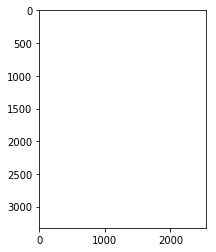

In [38]:
predicted_val = autoencoder.predict(x_val)
predicted_val[0] = predicted_val[0] * 255
img = cv2.merge((predicted_val[0],predicted_val[0],predicted_val[0]))
plt.imshow(img)
plt.show()